In [1]:
import numpy as np
#import mlflow
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from RecUnet import *
from train_RecUnet import *
%load_ext autoreload
%autoreload 2

#mlflow.autolog()

c:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Using device: cpu


In [2]:
data = dataset_seq()
geometry, damage, imp_shrinkage, obs_shrinkage = data.__getitem__(1000)
loaders = get_loaders(data, 1)
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(10, 1), dpi=200)
axs.flat[0].imshow(geometry[0], cmap='Greys')
axs.flat[0].set_axis_off()
for i in range(1,11):
    axs.flat[i].imshow(damage[i], cmap='Greys')
    axs.flat[i].set_axis_off()

: 

: 

In [4]:
args = {'lr' : 0.001, 'epochs' : 200, 'dev' : dev, 'name' : 'RecUnet'}

In [6]:
unet = RecUNet()

Using device: cpu


In [ ]:
unet = load_network(unet, args['name'], args)

In [15]:
losses_train, losses_val = train(unet, loaders, args)

Epoch: 0 batch: 0 mean train loss:  4872.1669921875
Epoch: 0 batch: 100 mean train loss:  4943.4604492188
Epoch: 0 batch: 200 mean train loss:  4664.3032226562
Epoch: 0 batch: 300 mean train loss:  4461.9472656250
Epoch: 0 batch: 400 mean train loss:  4504.3129882812
Epoch: 0 batch: 500 mean train loss:  4077.3027343750


KeyboardInterrupt: 

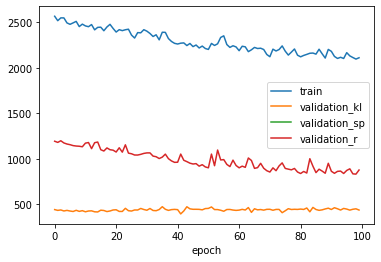

In [28]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

Test U-Net

In [2]:
data = dataset_seq()
loaders = get_loaders(data, 1)

In [3]:
unet = RecUNet()
args = {'lr' : 0.001, 'epochs' : 200, 'dev' : dev, 'name' : 'RecUnet'}
unet = load_network(unet, args['name']+'_9', args)
unet = unet.to(args['dev'])
unet.eval()

RecUNet(
  (e11): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=2, padding_mode=circular)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=2, padding_mode=circular)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=2, padding_mode=circular)
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=2, padding_mode=circular)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (at0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), groups=256)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circ

In [4]:
loss_damage = nn.BCELoss(reduction='none')
loss_shrinkage = nn.L1Loss(reduction='none')

L_dam = []
L_shr = []

for i, (geometry, damage, imp_shrinkage, obs_shrinkage) in enumerate(loaders['test']):
    geometry = geometry.to(args['dev'])
    damage = damage.to(args['dev'])
    imp_shrinkage = imp_shrinkage.to(args['dev'])
    obs_shrinkage = obs_shrinkage.to(args['dev'])
    l_seq_dam = []
    l_seq_shr = []
    seq = []
    for n in range(10):
        if n == 0:
            x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], damage[:,[n],:,:], damage[:,[n],:,:]], axis=1)
        else:
            x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], y.detach()], axis=1)
        # apply the network
        y = unet(x)
        # calculate mini-batch losses
        l_dam = loss_damage(y[:,[0],:,:], damage[:,[n+1],:,:]).sum().detach().item()
        l_shr = loss_shrinkage(y[:,1].mean((1,2)), obs_shrinkage[:,n+1]).sum().detach().item()
        l_seq_dam.append(l_dam)
        l_seq_shr.append(l_shr)
    L_dam.append(l_seq_dam)
    L_shr.append(l_seq_shr)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=50)
for l in range(l_seq_dam):
    axs.flat[0].plot(l_seq_dam, color='Blue')
for l in range(l_seq_shr):
    axs.flat[1].plot(l_seq_shr, color='Blue')

In [ ]:
n_samples = 10
fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(n_samples, 2), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow(x[i].detach().cpu().numpy(), cmap='Greys')
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(y[i-n_samples].numpy(), cmap='Greys')
    axs.flat[i].set_axis_off()